## Predicting Iowa House Prices with Linear Regression and Regularization
This project predicted house prices in Ames, Iowa with 79 features (2006-2010). The training set had 1460 observations and the test set had 1459 observations. 

I engineered features for linear regression models, and trained OLS, Lasso, Ridge, and Elastic Net in this notebook 

#### Feature Engineering:
* Outliers
* Skewness
* Missing Values (missing at random?)
* Categorical Variables (One-Hot Encoding)

#### Models:
* OLS
* Lasso
* Ridge
* Elastic Net
* Retrained models with PCA

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew 
from scipy import stats

# Feature engineering
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

# Modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import os
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warnings from sklearn and seaborn

In [2]:
df = pd.read_csv('/Users/qingchuanlyu/Documents/Application/Projects/Iowa Housing/house-prices-advanced-regression-techniques/train.csv')
df.shape

(1460, 81)

#### Feature Engineering

In [3]:
# The id feature doesn't have any predictive power.
df_ID = df['Id']
df.drop("Id", axis = 1, inplace = True)

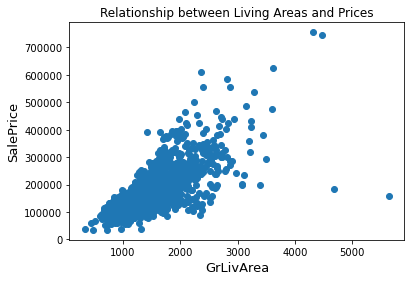

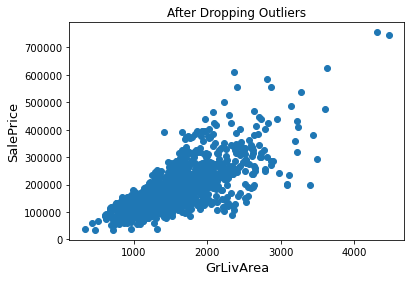

In [4]:
# What's the relationshiop between living areas and prices?
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Relationship between Living Areas and Prices')
plt.show()

# Two outliers in the bottom-right corner don't follow the main stream.
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(df['GrLivArea'], df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('After Dropping Outliers')
plt.show()


 mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution (Original)')

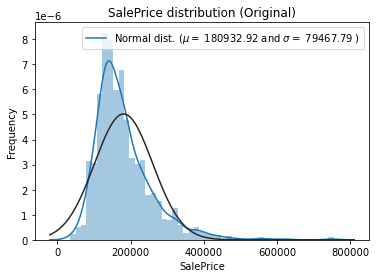

In [5]:
# Sale prices are not normally distributed.
sns.distplot(df['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Original)')


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'SalePrice distribution (Log Transformed)')

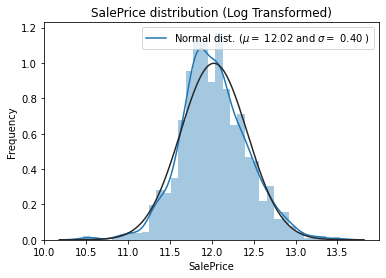

In [6]:
# Use log transformation to make right-skewed targets more normally distributed.
# Log1p(x) = log(1+x): plus 1 to avoid -inf
df["SalePrice"] = np.log1p(df["SalePrice"])

# The new distribution looks much more normally ditributed.
sns.distplot(df['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Log Transformed)')

[Text(0.5, 1.0, 'Missing GarageType by Neighborhood')]

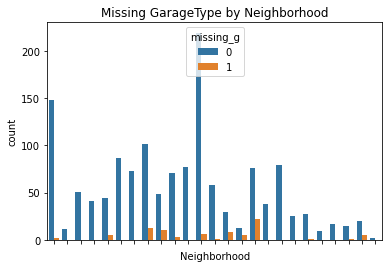

In [7]:
# Are missing values missing at random or not?
for col in ('MSSubClass', 'MasVnrType', 'BsmtQual', 'BsmtCond'\
            , 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC'\
            , 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType'\
            , 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
df['missing_g'] = np.where(df['GarageType']=="None", 1, 0)
# Does the distribution of the counts of garage types varies across neighborhoods?
ax = sns.countplot(x ='Neighborhood', hue = 'missing_g', data = df)
ax.set(xticklabels=[])
ax.set(title='Missing GarageType by Neighborhood')
# Missing values of garage types spread across most of few neighborhoods.

In [8]:
df.isnull().sum().sort_values(ascending = False)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
Electrical       1
Foundation       0
              ... 
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
MSSubClass       0
Length: 81, dtype: int64

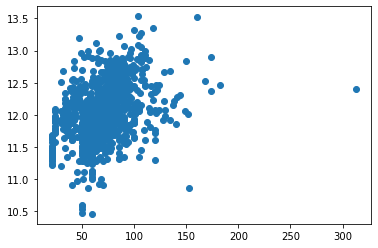

In [9]:
# LotFrontage variable is unlikely to be missing for having no lot. 
plt.scatter(df['LotFrontage'], df['SalePrice'])
# Positive correlation

In [10]:
# Do missing values of lotfrontage indicate larger or samller prices?
df.loc[df.LotFrontage.isnull() == True][['SalePrice']].mean()\
, df.loc[df.LotFrontage.isnull() == False][['SalePrice']].mean()

(SalePrice    12.062222
 dtype: float64,
 SalePrice    12.015762
 dtype: float64)

[Text(0.5, 1.0, 'Missing LotFrontage by Neighborhood')]

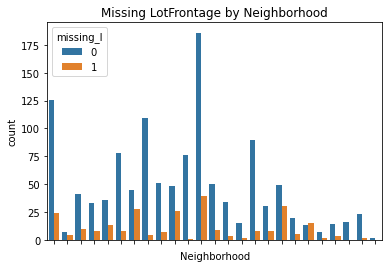

In [11]:
# Do the missing values of LotFrontage concentrate in a few neighborhoods?
df['missing_l'] = np.where(df['LotFrontage'].isnull(), 1, 0)
ax = sns.countplot(x = 'Neighborhood', hue = 'missing_l', data = df)
ax.set(xticklabels=[])
ax.set(title='Missing LotFrontage by Neighborhood')
# The missing values of LotFrontage spreads out across neighborhoods.

In [12]:
# Are the mean and median of lotfrontage different across neighborhoods?
lotfrontage_by_ngh = df.groupby(['Neighborhood'])\
                       .agg(mean_lotfrontage = ('LotFrontage', 'mean')\
                            , med_lotfrontage=('LotFrontage', 'median'))\
                       .reset_index()

In [13]:
lotfrontage_by_ngh.head(15)

,Neighborhood,mean_lotfrontage,med_lotfrontage
0,Blmngtn,47.142857,43.0
1,Blueste,24.000000,24.0
2,BrDale,21.562500,21.0
3,BrkSide,57.509804,52.0
4,ClearCr,83.461538,80.0
5,CollgCr,71.682540,70.0
6,Crawfor,71.804878,74.0
7,Edwards,64.811111,64.5
8,Gilbert,79.877551,65.0
9,IDOTRR,62.500000,60.0


In [14]:
# The median of LotFrontage varies by neighborhoods.
nbh_lot = df.groupby(df.Neighborhood)[['LotFrontage']].median()
df = df.merge(nbh_lot, on=["Neighborhood"], how='left', suffixes=('','_'))
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage_']).astype(int)
df = df.drop('LotFrontage_', axis=1)

In [15]:
# Replacing missing data with 0:
# GarageYrBlt, GarageArea and GarageCars: 
# Beacuse having no garage is equivalent to having no cars in such a garage;
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
# Because missing values are likely zero for having no basement.
for col in ('MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
# Utilities feature is a singleton.
df = df.drop(['Utilities'], axis=1)
# Data description says NA means 'Typical' in the Functional feature.
df["Functional"] = df["Functional"].fillna("Typical")
# For features with only one NA value, use mode of this var in the training set.
for col in ('KitchenQual', 'Electrical', 'Exterior1st', 'Exterior2nd', 'MSZoning', 'SaleType'):
    df[col] = df[col].fillna(df[col].mode()[0])

In [16]:
# Categorize categorical variables stored as numerical variables.
df['OverallCond'] = df['OverallCond'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [17]:
cates = df.select_dtypes(include=['object', 'category']).columns
for c in cates:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c])) 
    df[c] = lbl.transform(list(df[c]))

In [18]:
# Omit orders indicated by label encoders.
# PCA with One-Hot Encoder is not very meaningful, but it works.
df = pd.get_dummies(df)
print(df.shape)

(1458, 81)


In [19]:
num_vars = df.dtypes[(df.dtypes != "object") & (df.dtypes != 'category')].index
skewed_vars = df[num_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_vars})
skewness.head(15)
skewness = skewness[abs(skewness) > 0.8]
skewed_features = skewness.index
lam = 0.25
for f in skewed_features:
    df[f] = boxcox1p(df[f], lam)

In [20]:
y_df = df.SalePrice.values
df = df.drop('SalePrice', axis = 1)

In [22]:
# Check if there's any duplicated row before separting train and test data
df_ddp = df.drop_duplicates()

In [23]:
df_ddp.shape, df.shape

((1458, 80), (1458, 80))

In [21]:
# Split train and test data 70-30
X_train, X_test, y_train, y_test = train_test_split(df, y_df\
                                                    , test_size = 0.3, random_state = 0)

#### Modeling

In [26]:
metric = 'neg_root_mean_squared_error'

In [27]:
# Try simple OLS
linear_reg = LinearRegression().fit(X_train, y_train)
#print(linear_reg.score(X_test, y_test))
y_test_pred_lr = linear_reg.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_lr, squared=False))

0.01805071545476825


In [29]:
# Lasso.
lasso = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso = GridSearchCV(estimator = lasso, param_grid=param_grid_lasso, cv=10, scoring=metric, n_jobs=-1)
search_lasso.fit(X_train, y_train)
# Compute RMSE on test set
y_test_pred_lasso = search_lasso.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_lasso, squared=False))

0.017753386978970682


In [31]:
# Ridge.
ridge = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge = GridSearchCV(estimator = ridge, param_grid = param_grid_ridge, cv=10, scoring=metric, n_jobs=-1)
search_ridge.fit(X_train, y_train)
# Compute RMSE on test set
y_test_pred_ridge = search_ridge.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_ridge, squared=False))

0.017753386978970682


In [32]:
# Elastic Net.
elastic_net = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el = {
                'alpha' : np.linspace(0.0001, 0.001, 10),
                'l1_ratio' : np.linspace(0.6, 0.95, 20)
                }
search_el = GridSearchCV(estimator = elastic_net, param_grid = param_grid_el, cv=10, scoring=metric, n_jobs=-1)
search_el.fit(X_train, y_train)
print(f"{search_el.best_params_}")
# Compute RMSE on test set
y_test_pred_el = search_el.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_el, squared=False))

{'alpha': 0.0001, 'l1_ratio': 0.6}
0.017705648415758335


In [35]:
# Lasso with a PCA pipeline.
las_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("lasso", Lasso())
                      ])


las_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                        lasso__alpha = np.linspace(0.0001, 0.001, 10)
                       )
search_las = GridSearchCV(estimator = las_pipe, param_grid = las_param_grid, cv = 10, n_jobs=-1)   
search_las.fit(X_train, y_train)
print(f"{search_las.best_params_}")
# Compute RMSE on test set
y_test_pred_las = search_las.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_las, squared=False))

{'lasso__alpha': 0.00019999999999999998, 'reduce_dims__n_components': 0.95}
0.019180268130210863


In [36]:
# Ridge with a PCA pipeline.
rg_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("ridge", Ridge())
                      ])


rg_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                     ridge__alpha = np.linspace(0.0001, 0.001, 10)
                     )
search_rg = GridSearchCV(estimator = rg_pipe, param_grid = rg_param_grid, cv = 10, n_jobs=-1)   
search_rg.fit(X_train, y_train)
print(f"{search_rg.best_params_}")
# Compute RMSE on test set
y_test_pred_rg = search_rg.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_rg, squared=False))

{'reduce_dims__n_components': 0.95, 'ridge__alpha': 0.001}
0.01919712388394779


In [37]:
# Elastic Net with a PCA pipeline.
elnt_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("elnt", ElasticNet())
                      ])


elnt_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                       elnt__alpha = np.linspace(0.0001, 0.001, 10), 
                       elnt__l1_ratio = np.linspace(0.6, 0.95, 20)
                       )
search_elnt = GridSearchCV(estimator = elnt_pipe, param_grid = elnt_param_grid, cv = 10, n_jobs=-1)   
search_elnt.fit(X_train, y_train)
print(f"{search_elnt.best_params_}")
# Compute RMSE on test set
y_test_pred_elnt = search_elnt.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_elnt, squared=False))

{'elnt__alpha': 0.0003, 'elnt__l1_ratio': 0.7473684210526316, 'reduce_dims__n_components': 0.95}
0.019185955577353954
